# Introduction

In this notebook, we will walk through a case study, where an active learning strategy is employed to train a regression model adaptively. 

Active learning lets the model decide where in the parameter space it wants to learn next. By using only the necessary samples, an active learning strategy can effectively cut down the number of training samples, thus significantly reducing the computational burden of labeling training samples and improving the overall training efficiency.

In the current case study, the **Gaussian Process** is chosen as the target regression model, since this model type automatically estimates its prediction uncertainty (in the form of variance), thus permitting an esay implementation of the desired active learning strategy. 

To understand more about the intuition of the active learning approach, please check out the companion blog:

[Reducing Model Training Cost With Active Learning](https://towardsdatascience.com/reducing-model-training-cost-with-active-learning-255b40a2aa98)

In [54]:
# import all packages and set plots to be embedded inline
import numpy as np
import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

# Test Function

We select the following test function in this case study:

\begin{equation}
y(x) = 3(1-x)^2e^{(-x^2-1)}-10(0.2x-x^3)e^{-x^2}, \; x \in [-4, 1]
\end{equation}

Later on, we will train a Gaussian Process model to approximate this test function. To minimize the number of employed training samples, we will use an active learning strategy to intelligiently select one new sample at each learning iteration. Details of the active learning workflow is given in a latter section. 

For now, let's first plot this function to gain some intuition.

In [55]:
def test_function(x):
    y = 3*(1-x)**2*np.exp(-x**2-1) \
            - 10*(0.2*x-x**3)*np.exp(-x**2)
    return y

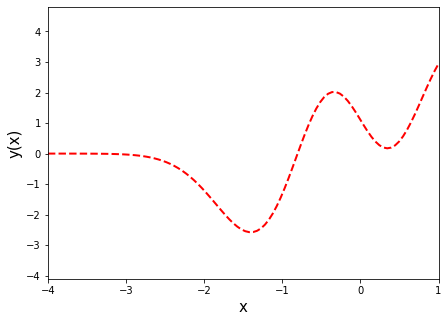

In [56]:
# Test function values
X_test = np.linspace(-4, 1, 100)
y_test = test_function(X_test)
            

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-4,1]);
ax.set_ylim([-4.1,4.8]);
plt.savefig('./images/Test_function.png')

From the figure above, we can see that the current test function describes a rather complex relationship between the input $x$ and the output $y(x)$: a flat region exists in the range [-4, -3], while multimodal responses dominate the remaining region. Since the correlation length varies significantly across the parameter space, it is challenging to construct a globally accurate Gaussian Process model.

# Active learning strategy

To reduce the number of samples required in the training process, we adopt an active learning strategy to iteratively refine the Gaussian Process (GP) model. 

## 1. The Workflow

The general of the adopted active learning strategy consists of the following steps:

1. Train a model based on the currently available data;
2. Employ a *learning function* to decide the next sample to label;
3. Label the selected sample;
4.Enrich the current training dataset with the labeled sample;
5. Repeat steps 1–4 until the model reaches the target accuracy.

A visual illustration of the above steps is given below.

<img src="./images/Active_Learning.png" width=500 height=300 />

## 2. The Learning Function

Our goal is to strengthen the model at the place where it makes the largest prediction error. As a result, we want a learning function that can estimate the prediction errors of the unseen samples.

The prediction error can be defined as 

\begin{equation}
L(x) = (y(x)-M(x))^2,
\end{equation}

where $y(x)$ and $M(x)$ are the true function value and model prediction value for sample $x$, respectively. According to the **bias-variance decomposition**, the expected value of $L(x)$ can be written as 

\begin{equation}
E[L(x)] = \underbrace{(y(x)-E[M(x)])^2}_{\text{bias}^2} + \underbrace{var[M(x)]}_{\text{variance}}
\end{equation}

However, computing $E[L(x)]$ is not straight-forward: although obtaining the variance value is easy (=model prediction variance), calculating the true bias value is simply impossible, as the true function output $y(x)$ is unknown. Therefore, we need to estimate the true bias value for an unseen sample $x$.

## 3. Estimating bias 

In this study, we use leave-one-out cross-validation error to estimate the prediction bias for an unseen sample $x^{\ast}$. Here are the steps:

1. We calculate cross-validation errors for all training samples $x_i, i=1,...,N$

\begin{equation}
e_{CV}^2(x_i) = (y(x_i)-M_{-i}(x_i))^2,
\end{equation}

where $y(.)$ is the true sample label and $M_{-i}(.)$ is the model trained using all the training samples except $(x_i, f(x_i))$.

2. We find the closest training samples $x_i$ to $x^{\ast}$, and use its cross-validation error to approximate the prediction bias at $x^{\ast}$:

\begin{equation}
\text{bias}(x^{\ast}) = e_{CV}^2(x_i), \; \underset{i}{\text{min}}|x^{\ast}-x_i|
\end{equation}

Now we have all the ingredients ready to calculate the expected prediction error $E[L(x)]$.

# Case study

## 1. Train an initial model

We start by training an initial GP model with 5 samples spreading evenly across the parameter space. Here, the GP implementation from Scikit-learn is adopted to train the GP model.

In [57]:
# Initial training data
X_train = np.linspace(-4, 1, 5).reshape(-1,1)
y_train = 3*(1-X_train)**2*np.exp(-X_train**2-1) \
            - 10*(0.2*X_train-X_train**3)*np.exp(-X_train**2)

In [58]:
# Train initial Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=1e-10, 
                                    normalize_y=True)
model.fit(X_train, y_train)

# GP prediction
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)

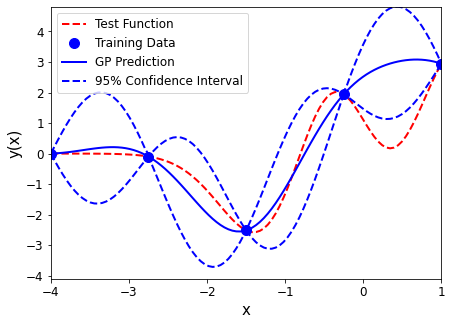

In [59]:
# Check GP prediction accuracy
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.plot(X_test,y_pred+1.96*pred_std.reshape(-1,1),'b--',
            lw=2,label='95% Confidence Interval')
ax.plot(X_test,y_pred-1.96*pred_std.reshape(-1,1),'b--',lw=2)
ax.set_ylim([-4.1,4.8]);
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12});
fig.savefig('./images/Initial_training.png')
fig

As can be seen from the figure above, the GP predictions match poorly with the true test function due to an insufficient number of training samples. In the following, we will adopt the active learning strategy discussed above to gradually enrich the training dataset and refine the GP model.

## 2. First iteration

Before we start iterating, we need to generate a pool of candidate samples. We will maintain this candidate pool for the subsequent iterations. At each iteration, we pick one sample from the candidate pool. This sample should yield the maximum expected prediction error value among all the candidate samples.

In [60]:
X_candidate = np.linspace(-4, 1, 1000).reshape(-1,1)

Now we are ready for the first iteration. We will do two things:

1. Calculate the expected prediction error $E[L(x)]$ for all candidate samples;
2. Select the sample with the largest $E[L(x)]$ value and append it to the current training dataset

In [61]:
# Calculate leave-one-out CV error for all training samples
LOOCV = (-1)*cross_val_score(model, X_train, y_train, 
                             cv=X_train.shape[0],
                            scoring='neg_mean_squared_error')

In [62]:
# Calculate expected prediction errors (EPE)
EPE = np.zeros_like(X_candidate)  
EPE_history = []      # Record the maximum EPE convergence history

for i,candidate in enumerate(X_candidate):
    
    # Calculate prediction variance
    prediction, prediction_std = model.predict([candidate], return_std=True)
    predict_var = prediction_std**2
    
    # Calculate prediction bias
    index = np.argmin(np.abs(candidate-X_train))
    bias = LOOCV[index]
    
    # Calculate EPE
    EPE[i] = predict_var+bias
    
EPE_history.append(np.max(EPE))

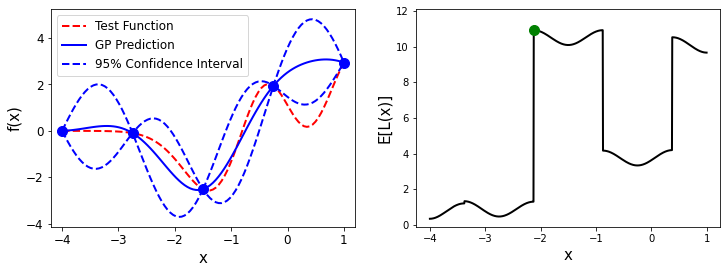

In [63]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

# GP prediction
axs[0].plot(X_test,y_test,'r--',lw=2,label='Test Function')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
axs[0].plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
axs[0].plot(X_test,y_pred+1.96*pred_std.reshape(-1,1),'b--',
            lw=2,label='95% Confidence Interval')
axs[0].plot(X_test,y_pred-1.96*pred_std.reshape(-1,1),'b--',lw=2)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].set_xlim([-4.2,1.2]);

# EPE 
axs[1].plot(X_candidate,EPE,'k-',lw=2)
axs[1].plot(X_candidate[np.argmax(EPE)],np.max(EPE),'go',markersize=10)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[L(x)]', fontsize=15)
axs[1].set_ylim([-0.1,12.1]);
fig.savefig('./images/First_iteration.png')

On the right, we can see the distribution of $E[L(x)]$ across the parameter space. The largest expected prediction error occurs at $x^{\ast}=-2.12$ (marked as a green dot). Therefore, in this first iteration, we pick $x^{\ast}=-2.12$ as the sample to enrich the current training dataset and update the GP model.

In [64]:
# Enrich training dataset
X_train = np.vstack((X_train, X_candidate[np.argmax(EPE)]))
y_train = np.vstack((y_train, test_function(X_candidate[np.argmax(EPE)])))

In [65]:
y_train

array([[-0.  ],
       [-0.1 ],
       [-2.51],
       [ 1.94],
       [ 2.94],
       [-0.89]])

In [66]:
# Update GP model
model.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=30, normalize_y=True)

In [67]:
# GP prediction
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)

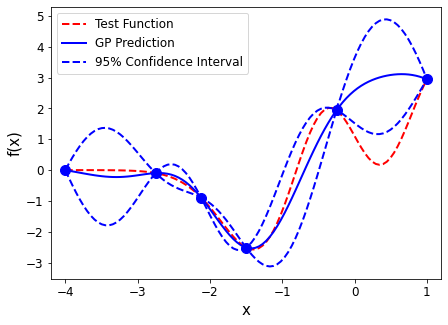

In [68]:
# Post-processing
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',lw=2,label='Test Function')
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
ax.plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
ax.plot(X_test,y_pred+1.96*pred_std.reshape(-1,1),'b--',
            lw=2,label='95% Confidence Interval')
ax.plot(X_test,y_pred-1.96*pred_std.reshape(-1,1),'b--',lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12})
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_xlim([-4.2,1.2]);

Thus, we have completed the first iteration.

## 3. Further iterations

First, we define a `EPE_Learning` function to calculate expected prediction error values.

In [69]:
# Expected prediction error-based active learning function
def EPE_learning(candidates, model):
    """Active learning function based on expected prediction error
    
        This function selects a new sample from candidate pool to enrich the current training 
        dataset. The sample gets selected if it has the maximum expected prediction error.
    
        Input:
        - candidates: pool of candidates to select sample from
        - model: the up-to-date GP model
        
        Output:
        - EPE: the expected prediction error
    """
    
    # Calculate leave-one-out CV errors
    LOOCV = (-1)*cross_val_score(model, model.X_train_, model.y_train_, 
                             cv=model.X_train_.shape[0],
                            scoring='neg_mean_squared_error')
    
    # Initiate EPE array
    EPE = np.zeros_like(candidates)  
    
    for i,candidate in enumerate(candidates):
        
        # Calculate prediction variance
        prediction, prediction_std = model.predict([candidate], return_std=True)
        predict_var = prediction_std**2
        
        # Calculate prediction bias        
        index = np.argmin(np.abs(candidate-model.X_train_))
        bias = LOOCV[index]
        
        # Calculate EPE
        EPE[i] = predict_var+bias
        
    return EPE

Then, we can start iterating.

In [70]:
# Active learning: iterations
iteration = 2

**The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [88]:
# 1-GP model training and predicting
model.fit(X_train, y_train)
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)
mse_score = np.round(mean_squared_error(y_test, y_pred),4)

# 2-Calculating EPE
EPE = EPE_learning(X_candidate, model)
EPE_history.append(np.max(EPE))

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current max EPE is {}'.format(str(np.max(EPE))) \
                    + os.linesep \
                    + 'Located at {}'.format(str(X_candidate[np.argmax(EPE)])) \
                    + os.linesep \
                    + 'Current MSE is {}'.format(str(mse_score))

print(Iteration_summary)

Iteration 8:
Current max EPE is 0.25152081194802833
Located at [-0.56]
Current MSE is 0.0


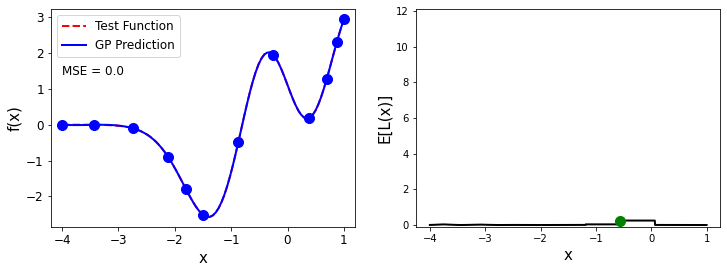

In [89]:
# 4-Iteration assessment
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(X_test,y_test,'r--',lw=2,label='Test Function')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
axs[0].plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
axs[0].text(-4, 1.4, 'MSE = {}'.format(str(mse_score)), fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].set_xlim([-4.2,1.2]);

axs[1].plot(X_candidate,EPE,'k-',lw=2)
axs[1].plot(X_candidate[np.argmax(EPE)],np.max(EPE),'go',markersize=10)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[L(x)]', fontsize=15)
axs[1].set_ylim([-0.1,12.1]);
fig.savefig('./images/Further_iteration.png')

# 5-Enrich training dataset
X_train = np.vstack((X_train, X_candidate[np.argmax(EPE)]))
y_train = np.vstack((y_train, test_function(X_candidate[np.argmax(EPE)])))
iteration += 1

After 7 iterations, we can see that the maximum $E[L(x)]$ value has dropped a lot compared with the first iteration. Correspondingly, this GP model is able to make accurate predictions across the entire parameter space. 

In practice, we monitor the change of maximum $E[L(x)]$ to define when the training can be terminated. In the current case study, we require that the maximum $E[L(x)]$ has to be smaller than 5% of the maximum $E[L(x)]$ at the first iteration.

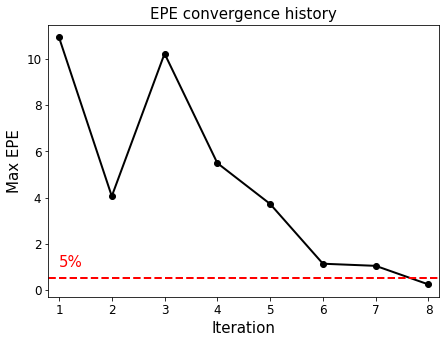

In [95]:
# EPE convergence history
fig, ax = plt.subplots(figsize=(7,5))

total_iteration = np.arange(1,iteration)
ax.plot(total_iteration, EPE_history, 'k-o', lw=2)
ax.plot([0,8.3],[EPE_history[0]*0.05, EPE_history[0]*0.05],'r--',lw=2)
ax.text(1,1,'5%',fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Max EPE', fontsize=15)
ax.set_title('EPE convergence history', fontsize=15)
ax.set_xlim([0.8, 8.2]);
fig.savefig('./images/EPE_evolution.png')